# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as m
import random

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

C:\Users\a.volodkina\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Functions

In [173]:
def reset_indexes(data):
    data.index = pd.RangeIndex(len(data.index))
    data.index = range(len(data.index))
    return data


def accuracy_score(y_train_v, y_train_pred):
    score = []
    for i in range(0, len(y_train_v)):
        score.append(metrics.accuracy_score(y_train_v[i], y_train_pred[i]))
    print(sum(score)/len(score))

    
def calc_r2(y_fact, y_pred):
    r2 = []
    for j in range(0, len(y_fact[0])):
        fact = []
        for i in range(0, len(y_fact)):
            fact.append(y_fact[i][j])

        pred = []
        for i in range(0, len(y_pred)):
            pred.append(y_pred[i][j])

        r2_score(fact, pred)
        r2.append(r2_score(fact, pred))
    return(sum(r2)/len(r2))


def plot_kmeans(database, col_x, col_y, kmeans):
    x = pd.to_numeric(database[col_x]).values
    y = pd.to_numeric(database[col_y]).values
    draw = pd.DataFrame({col_x: x,
                       col_y : y,
                       'Labels': kmeans.labels_})
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.set_size_inches(11.7, 8.27)
    sns.FacetGrid(draw, hue="Labels") \
       .map(ax.scatter, col_x, col_y) 
    ax.set_title('K-Means Clustering')
    ax.set_xlabel(col_x)
    ax.set_ylabel(col_y)
    
def create_factor_variable(variable, confines):
    y = variable.tolist()
    cat = pd.cut(y, confines).codes
    return cat + 2

def plot_all(database, col_x, col_y, kmeans):
    x = pd.to_numeric(database[col_x]).values
    y = pd.to_numeric(database[col_y]).values
    draw = pd.DataFrame({col_x: x,
                       col_y : y,
                       'Labels': kmeans})
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.set_size_inches(11.7, 8.27)
    sns.FacetGrid(draw, hue="Labels") \
       .map(ax.scatter, col_x, col_y) 
    ax.set_title('K-Means Clustering')
    ax.set_xlabel(col_x)
    ax.set_ylabel(col_y)
    

def calc_accuracy(stand_x):
    best_per_all = []
    speed = []
    pop1 = []
    pop2 =[]
    label_len = []
    
    for i in range(0,len(stand_x.groupby('labels')['labels'].count() ) ):
        res = stand_x[stand_x['labels']==i]
        label_len.append(len(res))
        for scale in range(1, 7):
            pop1.append( (len(res[res['Население1']==scale])/len(res))*100 )
            pop2.append( (len(res[res['Население2']==scale])/len(res))*100 )
            speed.append( (len(res[res['Другое расстояние']==scale])/len(res))*100 )

    new_speed = [speed[i:i+6] for i in range(0, len(speed), 6)]
    new_pop1 = [pop1[i:i+6] for i in range(0, len(pop1), 6)]
    new_pop2 = [pop2[i:i+6] for i in range(0, len(pop2), 6)]

    speed_max = [max(i) for i in new_speed]
    pop1_max = [max(i) for i in new_pop1]
    pop2_max = [max(i) for i in new_pop2]

    for i in range(len(pop1_max)):
        best = (speed_max[i] + pop1_max[i] + pop2_max[i])/3
        best_per_all.append((i, best, pop1_max[i], pop2_max[i], speed_max[i]))

    df_accuracy = pd.DataFrame(best_per_all, columns = ['label', 'best_per','pop1', 'pop2', 'speed'])
    df_accuracy['length'] = label_len
    accuracy = df_accuracy['best_per'].mean()
    return(df_accuracy, accuracy)



def calc_min_boud(array):
    res = array.median() - array.std()
    return res

def calc_max_boud(array):
    res = array.median() + array.std()
    return res

# Preparing df

In [3]:
df = pd.read_excel('standard_database_2.3.xlsx')

In [4]:
df.columns

Index(['Транспортная связь', 'Центр1', 'Тип ТЦ', 'Центр2',
       'Безальтернативность', 'Количество пересадок', 'Вид транспорта',
       'Время', 'Регулярность, раз в неделю', 'Расстояние', 'Категория связи',
       '№ класса', 'Население1', 'Население2', 'Пассажиропоток', 'Потенциал',
       'Другое расстояние', 'Другая скорость'],
      dtype='object')

In [5]:
df1 = df.replace('не найден', np.nan) # заменяем отсутствующие значения на nan
df1.isna().sum() # проверяем, если ли nan
df2 = df1.dropna() # удаляем nan
df2 = reset_indexes(df2) # восстанавливаем индексацию

In [6]:
df2 = df2.iloc[:, 1:].drop_duplicates(keep='first')

In [7]:
len(df2)

1072

In [8]:
stand_x = df2.loc[:, ['Население1', 'Население2', 'Другое расстояние']]
stand_x['Другое расстояние'] = stand_x['Другое расстояние']**2
confines_speed = [200, 500, 1000, 2000, 4000, 7000]
confines_speed1 = [x**2 for x in confines_speed]
confines_pop = [50000, 100000, 250000, 1000000, 3000000, 20000000]
factor_speed = create_factor_variable(stand_x['Другое расстояние'], confines_speed1)
factor_pop1 = create_factor_variable(stand_x['Население1'], confines_pop)
factor_pop2 = create_factor_variable(stand_x['Население2'], confines_pop)

stand_x['Другое расстояние'] = factor_speed
stand_x['Население1'] = factor_pop1
stand_x['Население2'] = factor_pop2

# AgglomerativeClustering

In [9]:
random.seed(1)

In [10]:
df_res = []
acc_res = []
for i in range(15, 61):
    clus = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
    cl1 = clus.fit_predict(stand_x)
    stand_x['labels'] = list(cl1)
    df0, acc = calc_accuracy(stand_x)
    df_res.append(df0)
    acc_res.append(acc)

In [11]:
n_classes = [i for i in range(15, 61)]
df_res_acc = pd.DataFrame({'n_classes':n_classes})
df_res_acc['accuracy'] = acc_res

In [12]:
df_res_acc

,n_classes,accuracy
0,15,65.510952
1,16,66.925837
2,17,67.400563
3,18,68.935576
4,19,70.148270
5,20,71.271761
6,21,72.065900
7,22,72.454035
8,23,73.532999
9,24,74.458097


In [13]:
df_res[-14]

,label,best_per,pop1,pop2,speed,length
0,0,63.218391,55.172414,58.620690,75.862069,29
1,1,84.946237,54.838710,100.000000,100.000000,31
2,2,86.666667,88.571429,74.285714,97.142857,35
3,3,70.512821,61.538462,100.000000,50.000000,26
4,4,73.913043,52.173913,86.956522,82.608696,23
5,5,83.908046,100.000000,51.724138,100.000000,29
6,6,89.898990,100.000000,100.000000,69.696970,33
7,7,62.500000,62.500000,75.000000,50.000000,8
8,8,72.222222,100.000000,54.166667,62.500000,24
9,9,85.897436,100.000000,100.000000,57.692308,26


In [14]:
clus = AgglomerativeClustering(n_clusters=47, affinity='euclidean', linkage='ward')
cl1 = clus.fit_predict(stand_x)
stand_x['labels'] = list(cl1)
df_clus47, acc_clus47 = calc_accuracy(stand_x)

In [15]:
acc_clus47

86.86246845190996

In [16]:
df2['labels'] = list(cl1)

# Visualazation

In [17]:
df3 = pd.read_excel('df_best_choice_aggclus_47_classes.xlsx')
df3 = df3.iloc[:,:-3]

In [18]:
df3.groupby('labels')['labels'].count()

labels
0     29
1     35
2     31
3     23
4     29
5      8
6     26
7     17
8     21
9     33
10    26
11     9
12    22
13    24
14    16
15     5
16    16
17    21
18    17
19    20
20    34
21    17
22    28
23    24
24    52
25     9
26    15
27    28
28    38
29    18
30    55
31    17
32    17
33    24
34    29
35    13
36    25
37    10
38    34
39    27
40    22
41    21
42    26
43    16
44    24
45     9
46    12
Name: labels, dtype: int64

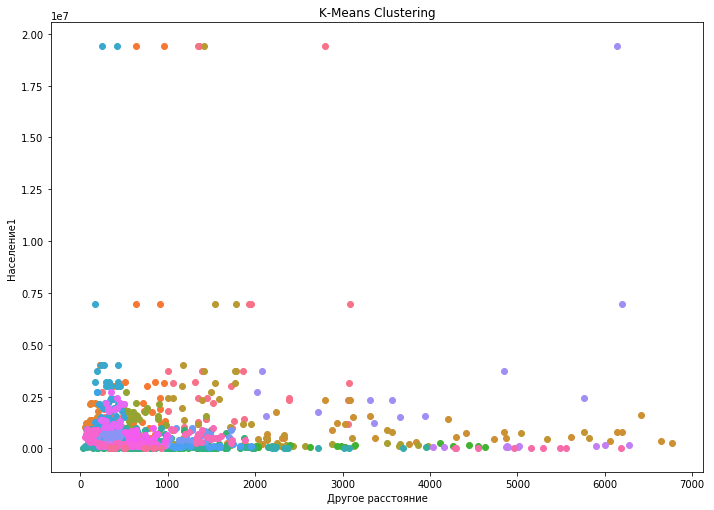

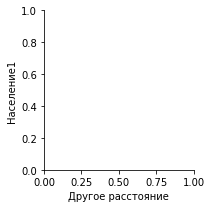

In [19]:
plot_all(df3, 'Другое расстояние', 'Население1', list(df3.labels))

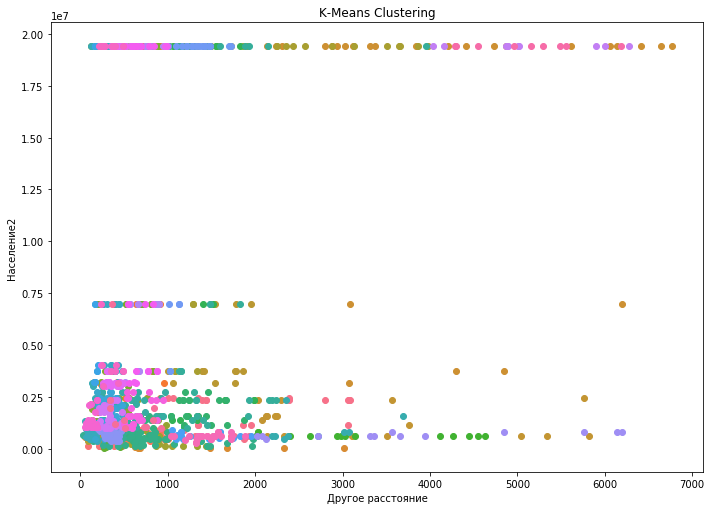

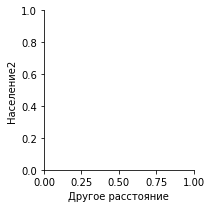

In [20]:
plot_all(df3, 'Другое расстояние', 'Население2', list(df3.labels))

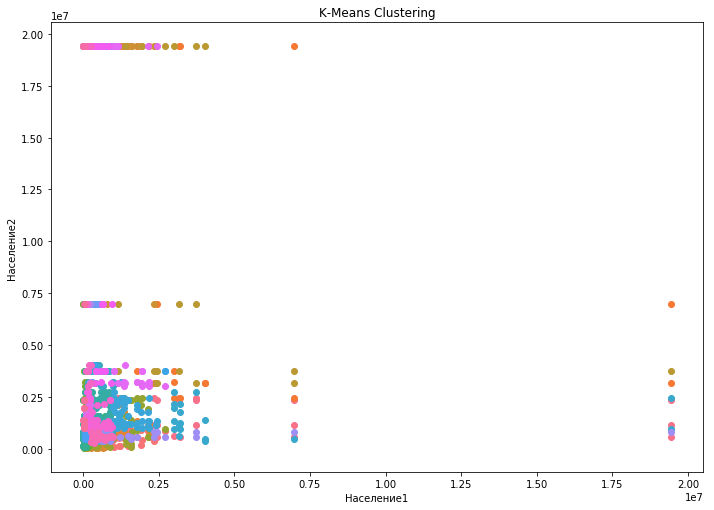

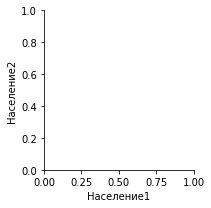

In [21]:
plot_all(df3, 'Население1', 'Население2', list(df3.labels))

In [22]:
df_right = pd.DataFrame(columns = list(df3.columns))
df_false = pd.DataFrame(columns = list(df3.columns))
for i in range(0,len(df3.groupby('labels')['labels'].count())):
    res = df3[df3['labels']==i]
    if len(res) >= 17:
        df_right = pd.concat([df_right.reset_index(drop=True), res.reset_index(drop=True)], axis = 0)
    else:
        df_false = pd.concat([df_false.reset_index(drop=True), res.reset_index(drop=True)], axis = 0)

In [23]:
print('Regression:', len(df_right.groupby('labels')['labels'].count() ), 
                         ' ', 'Median:', len(df_false.groupby('labels')['labels'].count() ) )

Regression: 35   Median: 12


In [24]:
df_right.groupby('labels')['labels'].count()

labels
0     29
1     35
2     31
3     23
4     29
6     26
7     17
8     21
9     33
10    26
12    22
13    24
17    21
18    17
19    20
20    34
21    17
22    28
23    24
24    52
27    28
28    38
29    18
30    55
31    17
32    17
33    24
34    29
36    25
38    34
39    27
40    22
41    21
42    26
44    24
Name: labels, dtype: int64

In [25]:
df_false.groupby('labels')['labels'].count()

labels
5      8
11     9
14    16
15     5
16    16
25     9
26    15
35    13
37    10
43    16
45     9
46    12
Name: labels, dtype: int64

# MultiOutputRegressor (linear)

In [26]:
r2_train = []
y_train_pred_all = []
X_train_all = []
y_train_all = []


for i in list(df_right.labels.unique()):
    label = df_right[df_right['labels']==i]
    X_train1 = label.loc[:, ['Население1', 'Население2', 'Другое расстояние', 'Вид транспорта', 
                              'Центр1', 'Тип ТЦ', 'Центр2', 'labels']]
    y_train1 = label.loc[:, ['Другая скорость', 'Регулярность, раз в неделю', 'Количество пересадок']]

    
    X_train_all.append(X_train1.values.tolist())
    y_train_all.append(y_train1.values.tolist())
    
    
    X_train = X_train1.iloc[:,:-5]
    y_train_v = y_train1.values
    X_train_v = X_train.values
    
    lin_reg = LinearRegression()
    multioutput_reg = MultiOutputRegressor(lin_reg, n_jobs=-1)
    multioutput_reg.fit(X_train_v, y_train_v)

    y_train_pred = multioutput_reg.predict(X_train_v)
    r2_tr = calc_r2(y_train_v, y_train_pred)
    r2_train.append(r2_tr)
    y_train_pred_all.append(y_train_pred.tolist())

In [27]:
len([i for i in r2_train if i > 0.38])

12

In [28]:
pd.DataFrame({'label': df_right.labels.unique(), 'r2':r2_train})

,label,r2
0,0,0.252456
1,1,0.138842
2,2,0.113251
3,3,0.568112
4,4,0.446354
5,6,0.241504
6,7,0.222710
7,8,0.610509
8,9,0.098692
9,10,0.148444


In [93]:
y_train_pred_all1 = [item for sublist in y_train_pred_all for item in sublist]